# Latent Diffusion

WIP implementation of latent diffusion from the paper [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).

Resources Used:
- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Variational AutoEncoder](https://keras.io/examples/generative/vae/)
- [Vector-Quantized Variational Autoencoders](https://keras.io/examples/generative/vq_vae/)
- [Denoising Diffusion Implicit Models](https://keras.io/examples/generative/ddim/)

In [1]:
import tensorflow as tf
from keras import layers
import keras
import matplotlib.pyplot as plt
import numpy as np
import math
from keras.preprocessing.image import ImageDataGenerator

## Hyperparameters

In [179]:
# Data.
image_size = 128
channels = 3
color_mode = 'rgb'
image_dataset_path = '../lsun_bedroom_sample/'
latent_dataset_path = '../lsun_bedroom_latent/'

# Autoencoder.
dropout = 0.1
autoencoder_batch_size = 128
autoencoder_epochs = 10
autoencoder_widths = [32, 64, 96]
autoencoder_block_depth = 3
latent_size = int(image_size / 2**len(autoencoder_widths))
beta_slope = 0.0002
beta_period = 10000
max_beta = 1.0
min_beta = 0.0

# Diffusion.
diffusion_batch_size = 2048
diffusion_epochs = 100
min_signal_rate = 0.02
max_signal_rate = 0.95
embedding_dims = 32
embedding_max_frequency = 1000.0
diffusion_widths = [32, 64, 96]
diffusion_block_depth = 2

## Data Generators

In [189]:
def preprocessing_function(image):
    image = image.astype(float) / 255.
    return image

idg = ImageDataGenerator(preprocessing_function = preprocessing_function)

def get_iterator(path, target_size, batch_size):
    iterator = idg.flow_from_directory(
        path,
        target_size = (target_size, target_size),
        batch_size = batch_size,
        color_mode = color_mode,
        classes = ['']
    )
    return iterator

image_iterator = get_iterator(image_dataset_path, image_size, autoencoder_batch_size)

Found 606250 images belonging to 1 classes.


## Visualization Functions

In [74]:
def plot_images(images):
    plt.figure(figsize = (50 * 3, 50))
    num_images = images.shape[0]
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')

    plt.tight_layout()
    plt.show()

In [116]:
def plot_performance(history, epochs, metric, log_scale_y=False):
    fig, ax = plt.subplots(1, 1)
    plt.title(metric)
    
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    
    x = list(range(1, epochs + 1))
    ty = history.history[metric]
    
    ax.plot(x, ty, label = 'train')
    
    if log_scale_y:
        plt.semilogy()
    
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [76]:
def plot_beta(beta_history):
    fig, ax = plt.subplots(1, 1)
    plt.title('beta history')
    ax.set_xlabel('steps')
    ax.set_ylabel('beta')
    
    x = list(range(1, len(beta_history)+1))
    
    ax.plot(x, beta_history)
    plt.grid()
    fig.canvas.draw()

## Variational Autoencoder

In [77]:
def EncoderBlock(widths):
    def apply(x):
        for width in widths:
            if x.shape[0] == width:
                residual = x
            else:
                residual = layers.Conv2D(width, (1, 1))(x)
            #x = layers.BatchNormalization()(x)
            for _ in range(autoencoder_block_depth):
                x = layers.Conv2D(width, (3, 3), activation='relu', padding='same')(x)
            x = layers.Add()([x, residual])
            x = layers.LayerNormalization()(x)
            x = layers.MaxPooling2D((2, 2), padding='same')(x)
        return x
    
    return apply

def DecoderBlock(widths):
    def apply(x):
        for width in widths:
            if x.shape[0] == width:
                residual = x
            else:
                residual = layers.Conv2D(width, (1, 1))(x)
            for _ in range(autoencoder_block_depth):
                x = layers.Conv2D(width, (3, 3), activation='relu', padding='same')(x)
            x = layers.Add()([x, residual])
            x = layers.LayerNormalization()(x)
            x = layers.UpSampling2D((2, 2))(x)
            
        x = layers.Conv2D(channels, (3, 3), activation='sigmoid', padding='same')(x)
        return x
    
    return apply

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=(z_mean.shape[1], z_mean.shape[2], channels))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [78]:
class BetaScheduler(keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        if(self.model.beta_schedule_step == self.model.beta_period):
            self.model.beta.assign(min_beta)
            self.model.beta_schedule_step = 0
        if self.model.beta < max_beta:
            self.model.beta.assign(self.model.beta_slope * self.model.beta_schedule_step)
        if self.model.beta >= max_beta:
            self.model.beta.assign(max_beta)
        
        self.model.beta_history.append(self.model.beta.numpy())
        self.model.beta_schedule_step += 1
        return

In [163]:
class VAE(keras.Model):
    def __init__(self, widths, beta_slope, beta_period, encoder=None, decoder=None):
        super().__init__()
        self.encoder_widths = widths
        self.decoder_widths = list(reversed(widths))
        
        if encoder != None:
            self.encoder = encoder
        else:
            self.encoder = self.create_encoder()
            
        if decoder != None:
            self.decoder = decoder
        else:
            self.decoder = self.create_decoder()
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
        self.beta_schedule_step = 0
        self.beta = tf.Variable(0.0, trainable=False)
        self.beta_slope = beta_slope
        self.beta_period = beta_period
        self.beta_history = []
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def create_encoder(self):
        input_image = layers.Input(shape=(image_size, image_size, channels))
        x = EncoderBlock(self.encoder_widths)(input_image)
        z_mean = layers.Conv2D(channels, (2, 2), padding='same')(x)
        z_log_var = layers.Conv2D(channels, (2, 2), padding='same')(x)
        z = Sampling()([z_mean, z_log_var])
        return keras.Model(input_image, [z_mean, z_log_var, z])
    
    def create_decoder(self):
        input_latent = layers.Input(shape=(latent_size, latent_size, channels))
        decoded = DecoderBlock(self.decoder_widths)(input_latent)
        return keras.Model(input_latent, decoded)
    
    def train_step(self, data):
        data = data[0] # Get rid of labels.
        
        with tf.GradientTape() as tape:
            # Encoding/Decoding.
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # loss.
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(data, reconstruction), axis=(1, 2)
                )
            )
                
            kl_loss = -self.beta * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def encode(self, data):
        _, _, z = self.encoder(data, training=False)
        return z
    
    def decode(self, data):
        x = self.decoder(data, training=False)
        return x

## Train VAE

In [80]:
vae = VAE(autoencoder_widths, beta_slope, beta_period)
vae.compile(optimizer='adam')

In [108]:
beta_scheduler = BetaScheduler()
vae_history = vae.fit(image_iterator, epochs=autoencoder_epochs, callbacks=[beta_scheduler])

Epoch 1/10
4737/4737 [==============================] - 1306s 276ms/step - loss: 118.9919 - reconstruction_loss: 94.4439 - kl_loss: 24.5802
Epoch 2/10
4737/4737 [==============================] - 1305s 275ms/step - loss: 143.5513 - reconstruction_loss: 103.3315 - kl_loss: 41.6477
Epoch 3/10
4737/4737 [==============================] - 1305s 275ms/step - loss: 126.6191 - reconstruction_loss: 94.7757 - kl_loss: 25.1840
Epoch 4/10
4737/4737 [==============================] - 1305s 276ms/step - loss: 141.0194 - reconstruction_loss: 102.7846 - kl_loss: 41.0550
Epoch 5/10
4737/4737 [==============================] - 1305s 276ms/step - loss: 132.3142 - reconstruction_loss: 95.3439 - kl_loss: 26.1646
Epoch 6/10
4737/4737 [==============================] - 1305s 276ms/step - loss: 137.4514 - reconstruction_loss: 102.0648 - kl_loss: 40.0848
Epoch 7/10
4737/4737 [==============================] - 1309s 276ms/step - loss: 136.3590 - reconstruction_loss: 96.1076 - kl_loss: 27.5031
Epoch 8/10
4737/4

In [ ]:
vae.encoder.save('data/encoder14')
vae.decoder.save('data/decoder14')

## Visualize Performance

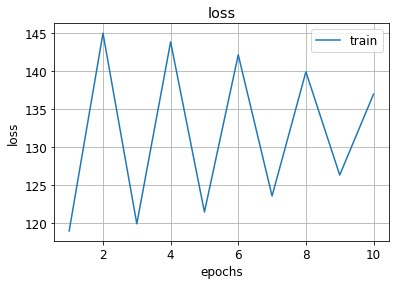

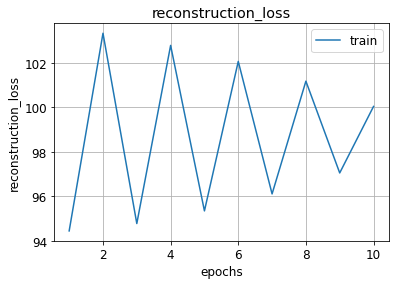

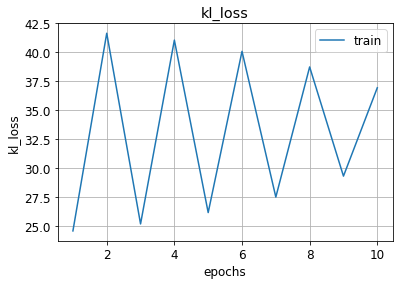

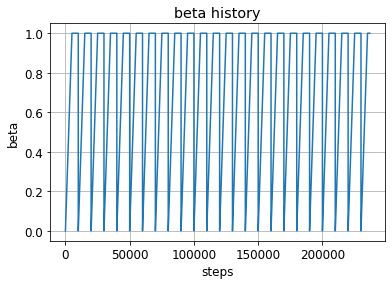

In [109]:
plot_performance(history=vae_history, epochs=10, metric='loss')
plot_performance(history=vae_history, epochs=10, metric='reconstruction_loss')
plot_performance(history=vae_history, epochs=10, metric='kl_loss')
plot_beta(vae.beta_history)

## Display Input, Encodings, and Decodings

Input:


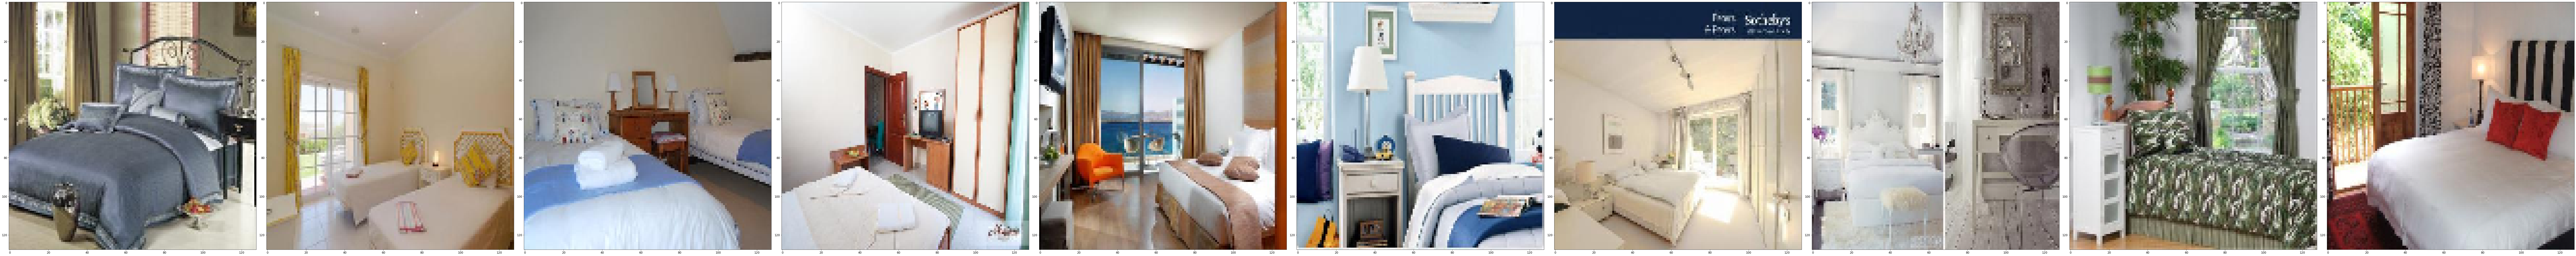

Encoded:


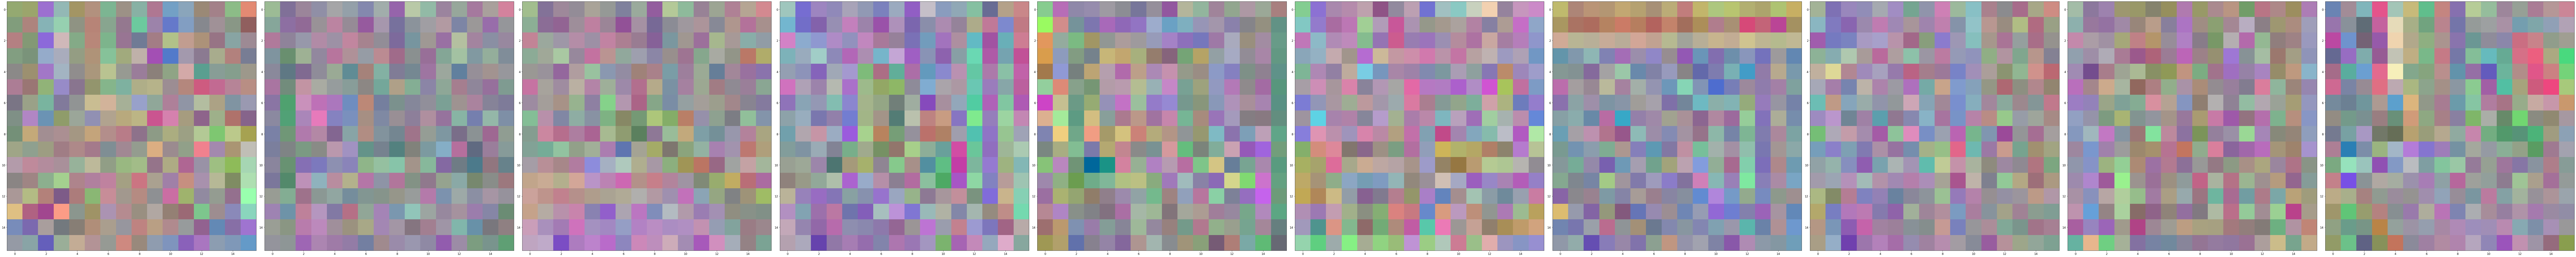

Decoded:


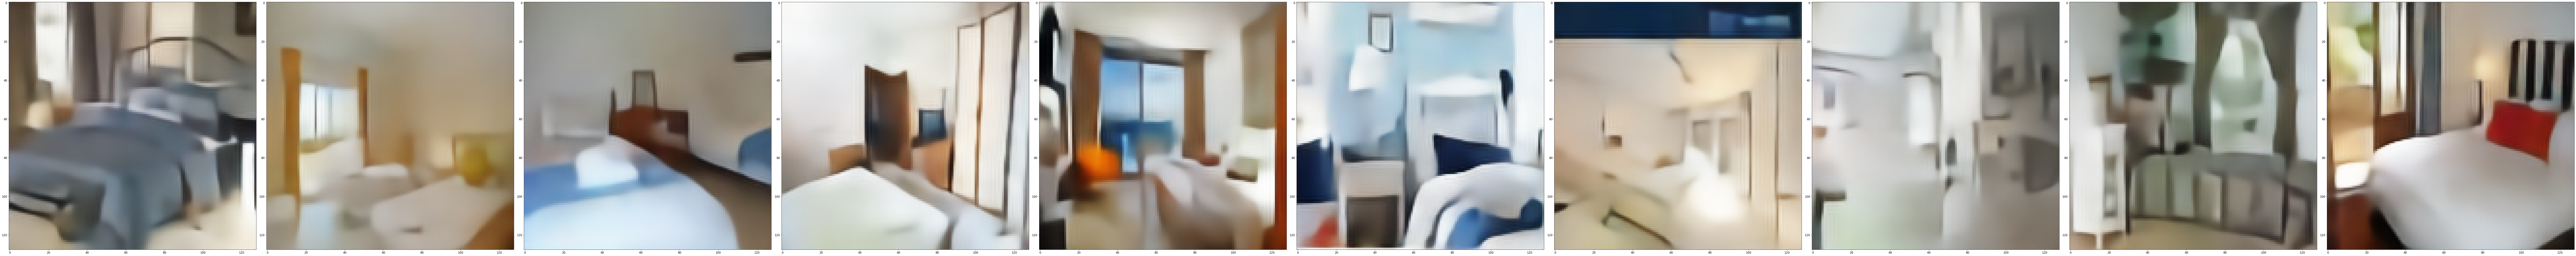

In [188]:
num_images = 10
training_image_iterator.reset()
input_images = training_image_iterator.next()[0][0 : num_images]
encoded_images = vae.encode(input_images).numpy()
decoded_images = vae.decode(encoded_images).numpy()

print('Input:')
plot_images(input_images)

print('Encoded:')
encoded_display = encoded_images
encoded_display -= np.min(encoded_display)
encoded_display /= np.max(encoded_display)
plot_images(encoded_display)

print('Decoded:')
plot_images(decoded_images)

## Encode and Save Images

In [186]:
encoding_image_iterator.reset()
for i in range(len(encoding_image_iterator)):
    encoded_images = vae.encode(encoding_image_iterator.next()[0])
    
    for k in range(len(encoded_images)):
        image_id = (i * encoder_batch_size) + k
        np.save(latent_dataset_path + str(image_id) + '.npy', encoded_images[k].numpy())

## Initialize Latent Iterator

In [187]:
#training_latent_iterator = ???

Found 0 images belonging to 1 classes.


## Denoising U-Net

In [18]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(tf.linspace(tf.math.log(embedding_min_frequency),
                         tf.math.log(embedding_max_frequency),
                         embedding_dims // 2))
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat([tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3)
    return embeddings

def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply

def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply

def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

In [134]:
class DiffusionModel(keras.Model):
    def __init__(self, input_size, block_depth, widths, encoder):
        super().__init__()
        
        self.normalizer = layers.Normalization()
        self.model = self.create_model(input_size, widths, block_depth)
        self.input_size = input_size
        self.encoder = encoder
    
    def create_model(self, input_size, widths, block_depth):
        noisy_input = keras.Input(shape=(input_size, input_size, channels))
        noise_variances = keras.Input(shape=(1, 1, 1))
        
        e = layers.Lambda(sinusoidal_embedding)(noise_variances)
        e = layers.UpSampling2D(size=input_size, interpolation='nearest')(e)
        
        x = layers.Conv2D(widths[0], kernel_size=1)(noisy_input)
        x = layers.Concatenate()([x, e])
        
        skips = []
        for width in widths[:-1]:
            x = DownBlock(width, block_depth)([x, skips])
            
        for _ in range(block_depth):
            x = ResidualBlock(widths[-1])(x)
        
        for width in reversed(widths[:-1]):
            x = UpBlock(width, block_depth)([x, skips])
            
        x = layers.Conv2D(channels, kernel_size=1, kernel_initializer='zeros')(x)
        
        return keras.Model([noisy_input, noise_variances], x)
    
    def compile(self, **kwargs):
        super().compile(**kwargs)
        
        self.noise_loss_tracker = keras.metrics.Mean(name='n_loss')
        self.image_loss_tracker = keras.metrics.Mean(name='i_loss')
    
    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker]
    
    def diffusion_schedule(self, diffusion_times):
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)

        return noise_rates, signal_rates
    
    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        pred_noises = self.model([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        
        return pred_noises, pred_images
    
    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_images = initial_noise.shape[0]    
        step_size = 1.0 / diffusion_steps
        
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images
            
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            
        return pred_images
    
    def generate(self, num_images, diffusion_steps):
        initial_noise = tf.random.normal(shape=(num_images, self.input_size, self.input_size, channels))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        return generated_images
    
    def train_step(self, images):
        images = images[0]
        images = self.encoder(images)
        
        noises = tf.random.normal(shape=(diffusion_batch_size, self.input_size, self.input_size, channels))
        
        diffusion_times = tf.random.uniform(
            shape=(diffusion_batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises
        
        with tf.GradientTape() as tape:
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )
            
            noise_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(noises, pred_noises), axis=(1, 2)
                )
            )
            
            image_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(images, pred_images), axis=(1, 2)
                )
            )
            
        grads = tape.gradient(noise_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)
            
        return {m.name: m.result() for m in self.metrics}

In [129]:
end_index = int(encoded_images.shape[0] / diffusion_batch_size) * diffusion_batch_size
encoded_images = encoded_images[:end_index]

In [141]:
model = DiffusionModel(latent_size, diffusion_block_depth, diffusion_widths, vae.encoder)
model.compile(optimizer='adam')

In [ ]:
diffuser_history = model.fit(dogs, epochs=100, batch_size=autoencoder_batch_size)

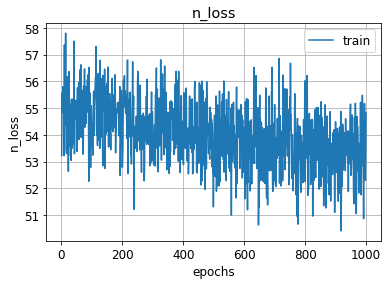

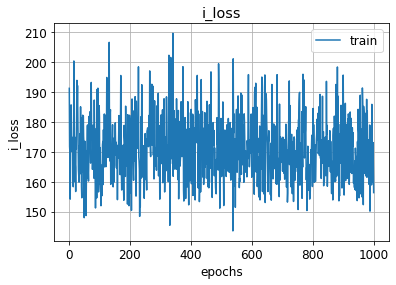

In [124]:
plot_performance(history=diffuser_history, epochs=10000, metric='n_loss')
plot_performance(history=diffuser_history, epochs=10000, metric='i_loss')

Encoded:


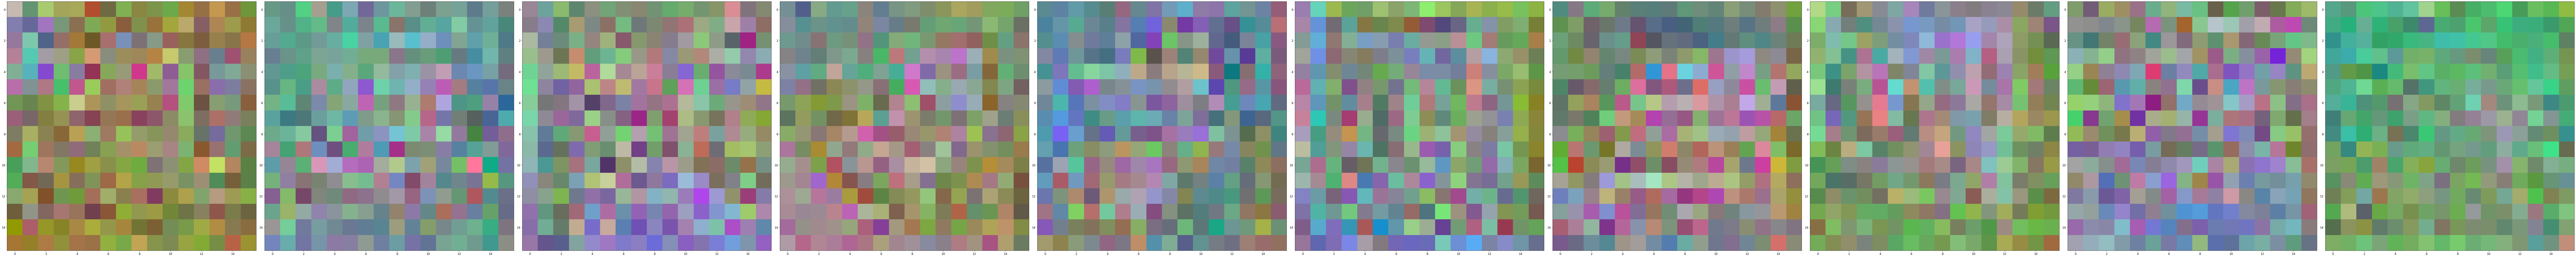

Decoded:


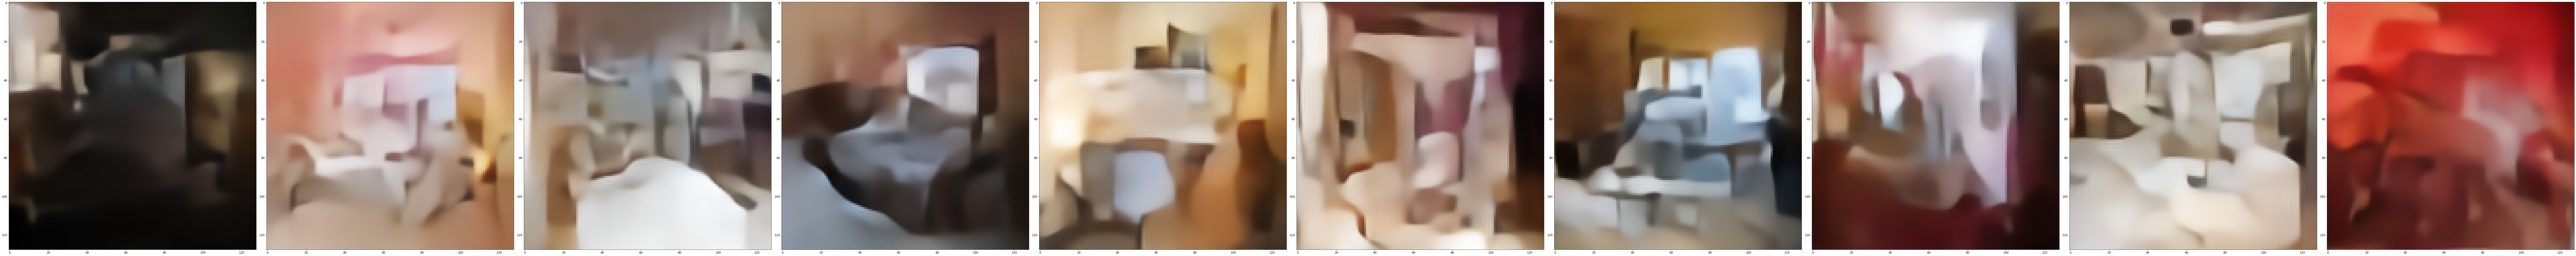

In [125]:
print('Encoded:')
generated_latents = model.generate(10, 20)
display_latents = generated_latents.numpy()
display_latents -= np.min(display_latents)
display_latents /= np.max(display_latents)
plot_images(display_latents)

print('Decoded:')
generated_images = vae.decode(generated_latents)
plot_images(generated_images.numpy())